In [1]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.3/539.3 KB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 KB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.9/704.9 KB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 41.4 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=14427d0365bce69073dfd02f8695566c91f3ea8fef688a01580fccbe0c8942b4
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/19892

In [2]:
# Import dependencies 
import numpy as np
import torch
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt

In [3]:
def heat_kernel_approximation_large(vals,vecs,t):
  H = torch.exp(-vals.unsqueeze(1) * t ).T * vecs @ vecs.T 
  return H

In [4]:
def heat_kernel_approximation_small(L,t,num_iters):
  H_0 = torch.eye(L.size(0)).double()
  H_t = H_0
  for i in range(num_iters):
    H_t = H_t - (t/num_iters)*L @ H_t
  return H_t

In [5]:
def heat_kernel(vals,vecs,t):
    H = torch.exp(-vals.unsqueeze(1) * t ).T * vecs @ vecs.T 
    return H

In [6]:
def get_adjecancy(graph_data):
  A=torch.zeros((graph_data.num_nodes,graph_data.num_nodes))
  A[graph_data.edge_index[0],graph_data.edge_index[1]]=1
  assert (A.transpose(0, 1) == A).all()
  return A

In [7]:
def eigendecomposition(graph_data):
  A = get_adjecancy(graph_data).double()
  D = torch.diag(torch.sum(A, 1))
  eig_val, eig_vec = torch.linalg.eigh((D - A).double())
  return eig_val,eig_vec, (D - A).double()

In [8]:
test_graphs = TUDataset(".","REDDIT-BINARY")

Extracting ./REDDIT-BINARY/REDDIT-BINARY.zip
Processing...
Done!


In [10]:
K = 50
error_large_t = torch.Tensor([0.]*K)
num_smaller = 0
for graph in test_graphs[:100]:
  if graph.num_nodes < K:
    num_smaller+=1
    continue
  eig_val, eig_vec, L = eigendecomposition(graph)
  H_t_large = heat_kernel(eig_val,eig_vec,10)
  for k in range(1,K+1):
    app_H_t_large = heat_kernel_approximation_large(eig_val[:k],eig_vec[:,:k],10)
    error_large_t[k-1]+= torch.sum(torch.abs(app_H_t_large-H_t_large)) / graph.num_nodes
error_large_t=error_large_t / (len(test_graphs)-num_smaller)


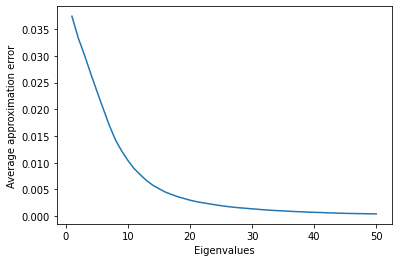

In [20]:
plt.plot(list(range(1,K+1)), error_large_t.tolist())
plt.xlabel("Eigenvalues")
plt.ylabel("Average approximation error")
#plt.show()
plt.savefig("large_t_app_error.pdf")

In [13]:
max_iters = 20
error_small_t = torch.Tensor([0.]*max_iters)
for graph in test_graphs[:100]:
  eig_val, eig_vec, L = eigendecomposition(graph)
  H_t_small = heat_kernel(eig_val,eig_vec,0.001)
  for k in range(1,max_iters+1):
    app_H_t_small = heat_kernel_approximation_small(L,0.01,k)
    error_small_t[k-1]+= torch.sum(torch.abs(app_H_t_small-H_t_small))/ graph.num_nodes
error_small_t=error_small_t / (len(test_graphs))

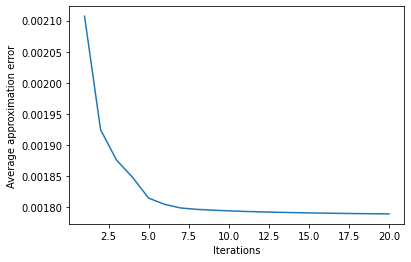

In [22]:
plt.plot(list(range(1,max_iters+1)), error_small_t.tolist())
plt.xlabel("Iterations")
plt.ylabel("Average approximation error")
#plt.show()
plt.savefig("small_t_app_error.pdf")